<a href="https://colab.research.google.com/github/marcinwolter/MachineLearning2020_projects/blob/main/Jedrzej_Walkowiak_2020_12_08_NN_Dense_2x80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple NN framework based on 
https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/exercises/intro_to_neural_nets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=intro_to_nn_tf2-colab&hl=en#scrollTo=Pu7R_ZpDopIj
and 
https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/exercises/multi-class_classification_with_MNIST.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=multiclass_tf2-colab&hl=en#scrollTo=siRC8a1hJvmq

In [ ]:
#@title Import modules

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#module which allows file transfer in google collab
from google.colab import files

#set pandas display options
#pd.options.display.float_format = "{:.2f}".format
#set numpy display options
np.set_printoptions(precision=3)

In [ ]:
#@title Import files from gdrive

#There are to other methods to do this, this one don't require installing new modules
#Alternative ways are gdown or GoogleDriveDownloader
#https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive/39225039#39225039
#https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

import requests

def download_file_from_google_drive(id, destination):

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

if __name__ == "__main__":
    file_id = '16pabxSKkArdYulPVorKkXT-ihtY1f9M2'
    destination = 'test_data.npy'
    download_file_from_google_drive(file_id, destination)

    file_id = '1CdW6RfeldJIu9ClgJggpxxwkvnWXoExQ'
    destination = 'validation_data.npy'
    download_file_from_google_drive(file_id, destination)

    file_id = '1meFbIDsfEULvs7fm61wZvsqPpY77hsaL'
    destination = 'training_data.npy'
    download_file_from_google_drive(file_id, destination)

In [ ]:
#uploaded = files.upload()
#Load files into numpy arrays
training_data = np.load('training_data.npy',allow_pickle=True)
test_data=np.load('test_data.npy',allow_pickle=True)
validation_data=np.load('validation_data.npy',allow_pickle=True)

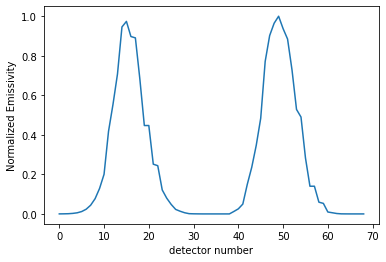

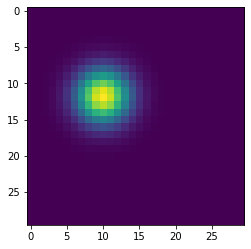

In [ ]:
# Create training and test data

#Training data
detectors_readings = np.stack(training_data[:,0])
detectors_readings = detectors_readings.reshape(-1,np.shape(detectors_readings)[1])
poloidal_crossection = np.stack(training_data[:,1])
poloidal_crossection = poloidal_crossection.reshape(-1,np.shape(poloidal_crossection)[1])

#Test data
test_detectors_readings = np.stack(test_data[:,0])
test_detectors_readings = test_detectors_readings.reshape(-1,np.shape(test_detectors_readings)[1])
test_poloidal_crossection = np.stack(test_data[:,1])
test_poloidal_crossection = test_poloidal_crossection.reshape(-1,np.shape(test_poloidal_crossection)[1])

#Validation data
validation_input=np.stack(validation_data[:,0])
validation_input=validation_input.reshape(-1,np.shape(validation_input)[1])
validation_output=np.stack(validation_data[:,1])
validation_output=validation_output.reshape(-1,np.shape(validation_output)[1])

#result visulalization test
#detectors plot
plt.plot(test_detectors_readings[1])
plt.ylabel('Normalized Emissivity')
plt.xlabel('detector number')
plt.show()

#poloidal crossection
vis_test_arr=np.reshape(np.array(test_poloidal_crossection), (-1,30, 30))
plt.imshow(vis_test_arr[1])

In [ ]:
#@title Export data from google collab (turned off)

if (False):
  print(detectors_readings)
  detectors_readings_df = pd.DataFrame(detectors_readings)
  detectors_readings_df.to_csv('detectors_readings.csv')
  files.download('detectors_readings.csv')

  print(poloidal_crossection)
  poloidal_crossection_df = pd.DataFrame(np.reshape(poloidal_crossection, (10000, 900)))
  poloidal_crossection_df.to_csv('poloidal_crossection.csv')
  files.download('poloidal_crossection.csv')

  # more about file transfer in google collab
  # https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971

In [ ]:
#@title Define the plotting function.

def plot_the_loss_curve(p_epochs, p_loss_t, p_loss_v):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(p_epochs, p_loss_t, label="Training Loss")
  plt.plot(p_epochs, p_loss_v, label="Validation Loss")
  plt.legend()
  plt.ylim([min(p_loss_t.min(),p_loss_v.min())*0.95, max(p_loss_t.max(),p_loss_v.max()) * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

#Some more examples:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

Defined the plot_the_loss_curve function.


In [ ]:
# NN definition
def create_model(m_learning_rate):
  #Sequential model means is used, which means no connetions between non-adjected layers
  model = tf.keras.models.Sequential()

  # Input layer with 69 neurons (one for each detetor)
  model.add(tf.keras.layers.Dense(units=69, name='Input'))

  # First hidden layer (80 neurons with sigmoid function, dense layer)
  model.add(tf.keras.layers.Dense(units=80, activation='relu', name='Hidden1'))

  # Regularization with dropout is set by adding dropout layers
  # The 'rate' parameter specifies the fraction of nodes that the model should drop out during training.  
  #model.add(tf.keras.layers.Dropout(rate=0.25))

  # Second hidden layer (80 neurons with sigmoid function, dense layer)
  model.add(tf.keras.layers.Dense(units=80, activation='relu', name='Hidden2'))

  # Output layer with 900 neurons (30x30)
  model.add(tf.keras.layers.Dense(units=900, name='Output'))

  # Construct the layers into a model that TensorFlow can execute.
  # Optimizer SGD stands for Stochastic Gradient Descent
  model.compile(optimizer=tf.keras.optimizers.SGD(lr=m_learning_rate),
                # Loss functions to minimize is set to MSE
                loss="mean_squared_error",
                #Metrics to monitore
                metrics=[tf.keras.metrics.MeanSquaredError()])
  return model

# To add L2 regularization, add following line as parameter of a layer 
# kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
# The l parameter is a regularization weight lambda
# e.g. model.add(tf.keras.layers.Dense(units=30, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l=0.01),name='Hidden1'))

In [ ]:
#NN training definition
def train_model(model, input_data, train_output, epochs, validation_split,
                batch_size=None):
  """Train the model by feeding it data."""

  history = model.fit(x=input_data, y=train_output, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = np.array(history.epoch)

  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  hist = pd.DataFrame(history.history)
  loss_t = hist["loss"]
  loss_v = hist["val_loss"]

  return epochs, loss_t, loss_v  

In [ ]:
# Hiperparameters definition

learning_rate = 20
number_of_epochs = 200
batch_size = 10
validation_split = 0.1


In [ ]:
#Create NN

Run_model = create_model(learning_rate)
print("Neural network has been set up")

#Create new arrays to store full record of loss function
epochs_full = np.array([])
loss_t_full = np.array([])
loss_v_full = np.array([])

Neural network has been set up


Epoch 1/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 2/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 3/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 4/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 5/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 6/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 7/200
210/210 [=

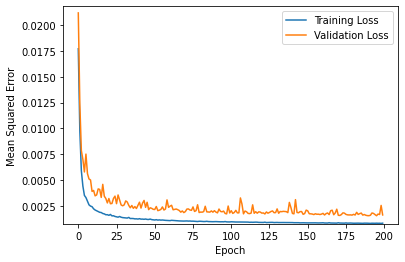

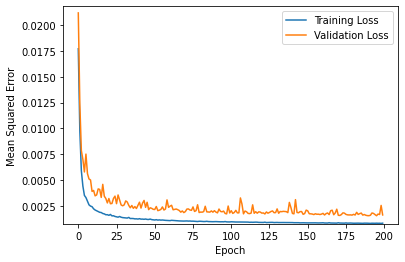


 Evaluate the new model against the test set:
31/31 [==============================] - 0s 1ms/step - loss: 9.8236e-04 - mean_squared_error: 9.8236e-04


[0.000982358236797154, 0.000982358236797154]

In [ ]:
#Trian NN

epochs, loss_t, loss_v = train_model(Run_model, detectors_readings, poloidal_crossection, number_of_epochs, validation_split, batch_size)

#plot loss function from training
plot_the_loss_curve(epochs, loss_t, loss_v)

#plot loss function from all trainings done on this NN
epochs_full = np.append(epochs_full,epochs+len(epochs_full))
loss_t_full = np.append(loss_t_full,loss_t)
loss_v_full = np.append(loss_v_full,loss_v)
plot_the_loss_curve(epochs_full, loss_t_full, loss_v_full)

# Evaluation agains separated test set
print("\n Evaluate the new model against the test set:")
Run_model.evaluate(x = test_detectors_readings, y = test_poloidal_crossection, batch_size=batch_size)

Orginal image:


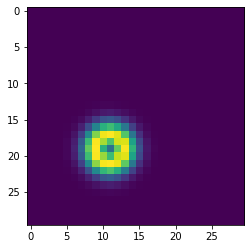

Reconstructed image:


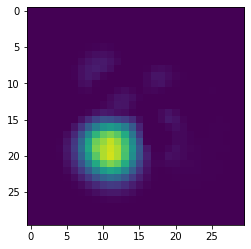

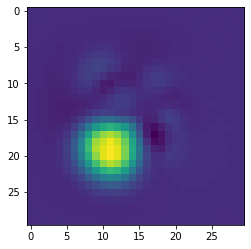

Scale: max= 0.930062  min= -0.13850817
Relative total emissivity error: -5.91 %


In [ ]:
# Use NN

#Choose number of sample to test
test_nr = 218

print("Orginal image:")
plt.imshow(validation_output[test_nr].reshape(30, 30))
plt.show()
results = Run_model.predict(validation_input)
vis_arr=np.reshape(np.array(results[test_nr]), (30, 30))
print("Reconstructed image:")

plt.imshow(vis_arr, vmin=0, vmax=1)
plt.show()

plt.imshow(vis_arr)
plt.show()
print("Scale: max=",np.max(vis_arr)," min=",np.min(vis_arr))

print("Relative total emissivity error:","{:.2f}".format(((np.sum(results[test_nr])-np.sum(validation_output[test_nr]))/np.sum(validation_output[test_nr]))*100), "%")

In [ ]:
max_em = 0
for itr in range(len(validation_data)):
  em = ((np.sum(results[itr])-np.sum(validation_output[itr]))/np.sum(validation_output[itr]))*100
  if abs(max_em)<abs(em):
     max_em = em
     max_em_index = itr
print(max_em)
print(max_em_index)

-214.4895331765338
114


In [ ]:
Run_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 69)                4830      
_________________________________________________________________
Hidden1 (Dense)              (None, 80)                5600      
_________________________________________________________________
Hidden2 (Dense)              (None, 80)                6480      
_________________________________________________________________
Output (Dense)               (None, 900)               72900     
Total params: 89,810
Trainable params: 89,810
Non-trainable params: 0
_________________________________________________________________
